In [1]:
import os
import jax
import braceexpand
import pandas as pd
import torchvision.transforms as T

from tqdm import tqdm
from pathlib import Path
from functools import partial
from torch.utils.data import DataLoader
from datasets import features, load_dataset

In [2]:
encoded_output = Path("aug_encoded_data")  # where we will save our encoded data
# good defaults for a TPU v3-8
batch_size = 16  # Per device
num_workers = 8  # For parallel processing
total_bs = batch_size * jax.device_count()  # You can use a smaller size while testing
save_frequency = 16  # Number of batches to create a new file (180MB for f16 and 720MB for f8 per file)

#================================================
# Custom dataloader begins
#================================================
data_dir = "../data40k"
data_files = {
    "train": os.path.join(data_dir, 'train.txt'),
    "validation": os.path.join(data_dir, 'validation.txt')
}
delimiter = " "

data = load_dataset('csv', data_files=data_files, delimiter=delimiter)
data = data.map(lambda example: {'images': os.path.join(data_dir, example['images']),
                    'captions': os.path.join(data_dir, example['captions'])})
# Not sure if this should be done on the fly
data = data.cast_column('images', features.Image())


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/gxu21/.cache/huggingface/datasets/csv/default-4a4b26069cc450a5/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [3]:
for i in range(16*6):
    print(i)
    print(data["train"][i]["images"].shape)

0


AttributeError: shape

In [4]:

# TODO check following transforms, dummy mean and std
transforms = T.Compose([
    T.RandomResizedCrop(256),
    T.ToTensor(),
    T.Normalize([0.500, 0.500, 0.500], [0.500, 0.500, 0.500])
])

def process(_transforms, ex):
    ex['images'] =  [_transforms(img) for img in ex['images']]
    ex['captions'] = [open(txt).read() for txt in ex['captions']]
    return ex

# in case we want to set different transforms for train and validation
data['train'].set_transform(partial(process, transforms))
train_loader = DataLoader(
    data['train'],
    batch_size=batch_size,
    num_workers=num_workers
)

data['validation'].set_transform(partial(process, transforms))
valid_loader = DataLoader(
    data['validation'],
    batch_size=batch_size,
    num_workers=num_workers
)

#================================================
# Custom dataloader ends
#================================================


In [5]:
for idx, batch in enumerate(tqdm(train_loader)):
    images, captions = batch['images'], batch['captions']
    images = images.permute(0, 2, 3, 1)
print(idx)

100%|███████████████████████████████████████| 2413/2413 [02:04<00:00, 19.34it/s]

2412


100%|███████████████████████████████████████| 2413/2413 [02:04<00:00, 19.36it/s]


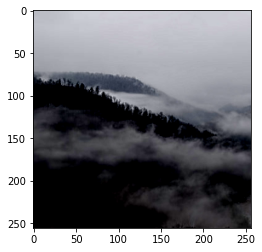

In [6]:
for idx, batch in enumerate(tqdm(train_loader)):
    images, captions = batch['images'], batch['captions']
    images = images.permute(0, 2, 3, 1)
    
for image in images:
    break
import matplotlib.pyplot as plt
plt.imshow(image)

In [ ]:

encoded_output = Path("aug_encoded_data/validation") 
VQGAN_REPO, VQGAN_COMMIT_ID = (
    "dalle-mini/vqgan_imagenet_f16_16384",
    "85eb5d3b51a1c62a0cc8f4ccdee9882c0d0bd384",
)

from vqgan_jax.modeling_flax_vqgan import VQModel
from flax.jax_utils import replicate

from flax.training.common_utils import shard
from functools import partial


vqgan = VQModel.from_pretrained(VQGAN_REPO)
vqgan_params = replicate(vqgan.params)

@partial(jax.pmap, axis_name="batch")
def p_encode(batch, params):
    # Not sure if we should `replicate` params, does not seem to have any effect
    _, indices = vqgan.encode(batch, params=params)
    return indices

def encode_dataset(dataloader, output_dir, save_frequency):
    output_dir.mkdir(parents=True, exist_ok=True)
    all_captions = []
    all_encoding = []
    n_file = 1
    for idx, batch in enumerate(tqdm(dataloader)):
        images, captions = batch['images'], batch['captions']
        images = images.permute(0, 2, 3, 1)
        images = images.numpy()
        n = len(images) // 8 * 8
        if n != len(images):
            # get the max number of images we can (multiple of 8)
            print(f"Different sizes {n} vs {len(images)}")
            images = images[:n]
            captions = captions[:n]
        if not len(captions):
            print(f"No images/captions in batch...")
            continue
        images = shard(images)
        encoded = p_encode(images, vqgan_params)
        encoded = encoded.reshape(-1, encoded.shape[-1])
        all_captions.extend(captions)
        all_encoding.extend(encoded.tolist())

        # save files
        if (idx + 1) % save_frequency == 0:
            print(f"Saving file {n_file}")
            batch_df = pd.DataFrame.from_dict(
                {"caption": all_captions, "encoding": all_encoding}
            )
            batch_df.to_parquet(f"{output_dir}/{n_file:03d}.parquet")
            all_captions = []
            all_encoding = []
            n_file += 1

    if len(all_captions):
        print(f"Saving final file {n_file}")
        batch_df = pd.DataFrame.from_dict(
            {"caption": all_captions, "encoding": all_encoding}
        )
        batch_df.to_parquet(f"{output_dir}/{n_file:03d}.parquet")

#encode_dataset(train_loader, output_dir=encoded_output, save_frequency=save_frequency)
encode_dataset(valid_loader, output_dir=encoded_output, save_frequency=save_frequency)
# similarly encode for validation data
